Basestock Policy:

replenishment_needed [0, 23, 20, 40]
replenishment [38, 96, 82, 60]
Old Inventory position is [37, 9, 10, 6]
New Iventory postion is [75, 105, 92, 66]
Total cost for 1 is 10238.82691153984
Q-table after episode 1: {(0, 38): 38, (23, 96): 96, (20, 82): 82, (40, 60): 60}
replenishment_needed [25, 11, 0, 39]
replenishment [38, 57, 44, 40]
Old Inventory position is [19, 15, 21, 13]
New Iventory postion is [57, 72, 65, 53]
Total cost for 2 is 6578.826911539841
Q-table after episode 2: {(0, 38): 38, (23, 96): 96, (20, 82): 82, (40, 60): 60, (25, 38): 38, (11, 57): 57, (0, 44): 44, (39, 40): 40}
replenishment_needed [21, 11, 20, 55]
replenishment [64, 76, 51, 62]
Old Inventory position is [17, 7, 12, 11]
New Iventory postion is [81, 83, 63, 73]
Total cost for 3 is 6358.826911539841
Q-table after episode 3: {(0, 38): 38, (23, 96): 96, (20, 82): 82, (40, 60): 60, (25, 38): 38, (11, 57): 57, (0, 44): 44, (39, 40): 40, (21, 64): 64, (11, 76): 76, (20, 51): 51, (55, 62): 62}
replenishment_needed [

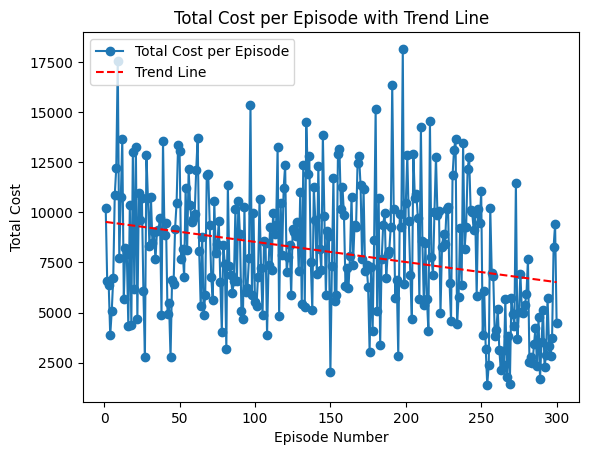

Model power: 1.9818192985695682
slope -10.05719546890063
Lowest cost among all episodes: 1388.8269115398405


In [6]:
import numpy as np
from math import ceil
from scipy.stats import norm
from scipy.stats import linregress
import geopy.distance
import random
import matplotlib.pyplot as plt

class sSpolicy:
    def __init__(self, nStores=4, num_trucks=4):
        #initializing the class with the required inputs
        self.data = dict()
        self.nStores = nStores
        self.num_trucks = num_trucks
        
        ## Latitute coordinates; First element is depot
        self.lat = np.array([52.4572735973313,
                             52.533031250357,
                             52.5326620602486,
                             52.4965099365104,
                             52.4921203344399
                             ])
        
        ## Longitude coordinates, first element is depot
        self.lon = np.array([13.3878670887734,
                             13.387585268824,
                             13.398873880729,
                             13.4224855541126,
                             13.4226572154896,
                             ])
        
        self.data['distance_matrix'] = np.zeros(shape = [self.nStores + 1, self.nStores + 1])
        
        # Variable transport cost per unit distance
        self.transportCost = 5
        
        # Fixed transport cost per used route
        self.fixedTransportCost = 100
        
        # The distance matrix is in the end the cost matrix. We take the distance
        # between coordinates and multiply it with the variable transportCost
        for i in range(self.nStores + 1):
            for j in range(self.nStores + 1):
                coords_1 = (self.lat[i], self.lon[i])
                coords_2 = (self.lat[j], self.lon[j])
                self.data['distance_matrix'][i][j] = geopy.distance.geodesic(coords_1, coords_2).km * self.transportCost
                                           
        # The vehicle capacity, the number of vehicles
        self.data['vehicle_capacity'] = 50
        self.data['num_vehicles'] = 4

        # Information of the stores (holding cost, lost-sales cost, capacity)
        self.c_holding = 100 
        self.c_lost = 100
        self.capacity = 1000
        self.orderUpTo = 100

    #Demand follows a normal distribution -  Derived from the demand table provided
    def demand(self):
        demand = [
            ceil(abs(np.random.normal(17, 7, 1)[0])),
            ceil(abs(np.random.normal(14, 6, 1)[0])),
            ceil(abs(np.random.normal(13, 4, 1)[0])),
            ceil(abs(np.random.normal(16, 6, 1)[0]))
        ]
        
        
        return demand
    
    def base_stock_level(self):
        c_holding = 100 
        c_lost = 100
    
        critical_ratio = c_lost / (c_lost + c_holding)
        k = norm.ppf(critical_ratio)
    
        # Call demand function to get demand for each store
        demand = self.demand()
        base_stock_level  =[0]*4
        # Calculate base stock level for each store - I assumed basestock level is 2 times the demand of each store. Thumb rule.Varies between each store
        for i in range(self.nStores):
            base_stock_level[i] = demand[i]*2
        return base_stock_level
    
    #The actions are defined in steps of 5
    def define_actions(self):
        actions = list(range(0, int(self.orderUpTo) + 1, 1))
        return actions

    #Reset function is to reset the environment everytime at the start of the episode
    def reset(self):
        self.inventories = self.base_stock_level()
        return self.inventories
    
    #Step for each episode    
    def step(self, q_table,epsilon):
        # Call the action definition
        actions = self.define_actions()
        global a
        a += 1
        
        # Initialize costs and other variables
        costs = []
        inventory = [0]*4
        replenishment = [0]*4
        
        # Get current inventories
        current_inventories = self.reset()
        
        # Calculate demand
        current_demand = self.demand()

        replenishment_needed = [0]*4

        #Checking if the exploration time has ended or not
        if a >= creating_table:
            epsilon = random.random()

        # Calculate replenishment needed for each store
        for i in range(self.nStores):
            inventory[i] = current_inventories[i] - current_demand[i]
            replenishment_needed[i] = max(0, self.base_stock_level()[i] - inventory[i])
            found = False

            for key in q_table.keys(): #finding whether the replenishment_needed is already in the q_table or not
                if key[0] == replenishment_needed[i]:
                    found = True
                    break

            if a >= creating_table and found==True  and epsilon >= 0.2: #Here if epsilon is commented, it depicts greedy strategy, if not, it represents the epsilon greedy strategy
                # Exploit: choose action from Q-table
                finding = []
                for key,value in q_table.items(): #getting the minimum value of replenishment for replenishment_needed present in the table
                    if key[0]==replenishment_needed[i]:
                        finding.append(value)

                #Getting the minimum value that has the lowest cost. Basically we are choosing the best reward        
                if finding:
                    replenishment[i] = min(j for j in finding if j > replenishment_needed[i])

            else:
                # Explore: choose a random action
                explore = 1
                #Creating a table here if the episodes does a exploration 
                replenishment[i] = random.choice([a for a in actions if a >= replenishment_needed[i]])
                tuple = (replenishment_needed[i],replenishment[i])
                if tuple not in q_table:
                    q_table[(replenishment_needed[i],replenishment[i])] = replenishment[i] # Use cost directly for value. Since it is just a reference for choosing the best action here.

        #Initializing other variables for calculating the costs involved in each episode
        num_trucks = self.num_trucks
        trucks_load = [0]*4
        capacity = [0]*4
        replenished_by_trucks = [0]*4
        routes = [[] for _ in range(num_trucks)]
        num_trucks_used = 0
        lost_sales = 0
        total_distance = 0 
        truck_index = 0

        #Printing the parameters for our reference
        print("replenishment_needed",replenishment_needed)
        print("replenishment",replenishment)
        print("Old Inventory position is",inventory)
        new_inventory = [0,0,0,0]
        for i in range(len(replenishment)):
            new_inventory[i]=inventory[i]+replenishment[i]
        print("New Iventory postion is",new_inventory)
        
        #Replenishment is carried out by the trucks
        for j in range(len(replenishment)):
            if replenishment[j] != 0:
                total_distance += self.data['distance_matrix'][0][j + 1]  # Add distance from depot to store
                if replenishment[j] <= self.data['vehicle_capacity']:
                    replenished_by_trucks[truck_index] = replenishment[j]
                    routes[truck_index].append(j)
                    truck_index += 1
                else:
                    while replenishment[j] > 0 and truck_index < num_trucks:
                        if replenishment[j] > self.data['vehicle_capacity']:
                            replenished_by_trucks[truck_index] = self.data['vehicle_capacity']
                            replenishment[j] -= self.data['vehicle_capacity']
                            routes[truck_index].append(j)
                            lost_sales += replenishment[j]
                            replenishment[j] = 0
                            truck_index += 1
                
                if truck_index >= num_trucks:
                    lost_sales += replenishment[j]
                    replenishment[j] = 0
            else:
                replenished_by_trucks[j] = 0
            
        # Calculate the total cost
        variable_transport_cost = total_distance * self.transportCost
        fixed_transport_cost = (num_trucks - np.count_nonzero(replenished_by_trucks == 0)) * self.fixedTransportCost
        lost_sales_cost = lost_sales * self.c_lost
        replenishment_cost = sum(replenishment) * 10
        total_cost = variable_transport_cost + fixed_transport_cost + lost_sales_cost + replenishment_cost
        print("Total cost for %s is %s" % (a,total_cost))

        return inventory, replenishment, trucks_load, replenished_by_trucks, routes, lost_sales, total_distance, total_cost

# Run the algorithm for 60 episodes
a=0 #A variable used for calculating the number of episodes to trigger exploitation when needed.
num_episodes = 300 #total number of episodes
creating_table = 250 #Number of episodes that use exploration strategy by choosing random action and evaluating its cost
explore = 0 #Flag varable for reference
total_costs = [] #List of total costs incurred in each episodes. This is further used in plotting
q_table = {} #Initializing q_table for appending values in the form of tuples. It enables us to use Q-Learning to choose the best action learned from experience
# Set epsilon for exploration-exploitation
epsilon = 0.2 

#Acts as a form of Monte Carlo Simulation for the number of episodes but here the reward value for a episode is not updated because of episode's structure
for episode in range(num_episodes):
    # Initialize an instance of sSpolicy class for each episode
    ssp = sSpolicy()
    # Run the step method to get the total cost
    _, _, _, replenished_by_trucks, _, _, _, total_cost = ssp.step(q_table, epsilon)
    # Append the total cost to the list
    total_costs.append(total_cost)
    # Print Q-table after each episode for debugging
    print(f"Q-table after episode {episode+1}: {q_table}")
# Print total costs for all episodes
for i, cost in enumerate(total_costs):
    print(f"Total cost for episode {i+1}: {cost}")

# Plot total costs for all episodes
plt.plot(range(1, num_episodes + 1), total_costs, marker='o', label='Total Cost per Episode')

# Calculate the trend line - For Visualizing the trend of the total costs in each episodes. This acts as a indicator that the model learns.
slope, intercept, r_value, p_value, std_err = linregress(range(1, num_episodes + 1), total_costs)
trend_line = [slope * x + intercept for x in range(1, num_episodes + 1)]

# Plot the trend line
plt.plot(range(1, num_episodes + 1), trend_line, color='red', linestyle='--', label='Trend Line')
plt.xlabel('Episode Number')
plt.ylabel('Total Cost')
plt.title('Total Cost per Episode with Trend Line')
plt.legend()
plt.show()

#testing the power of this model:For comparing the model with different episodes and startegies
exploration_cost = sum(total_costs[:50]) / 50
exploitation_cost = sum(total_costs[-40:]) / 40
model_power = exploration_cost / exploitation_cost
print(f"Model power: {model_power}")
print("slope",slope)
# Calculate the lowest cost among all episodes
lowest_cost = min(total_costs)
print(f"Lowest cost among all episodes: {lowest_cost}")


(s,S) Policy:

replenishment_needed [0, 0, 0, 16]
replenishment [75, 43, 16, 26]
Old Inventory position is [61, 59, 59, 54]
New Iventory postion is [136, 102, 75, 80]
Total cost for 1 is 6748.826911539841
Q-table after episode 1: {(0, 75): 75, (0, 43): 43, (0, 16): 16, (16, 26): 26}
replenishment_needed [24, 17, 17, 21]
replenishment [90, 71, 99, 27]
Old Inventory position is [46, 53, 53, 49]
New Iventory postion is [136, 124, 152, 76]
Total cost for 2 is 14758.82691153984
Q-table after episode 2: {(0, 75): 75, (0, 43): 43, (0, 16): 16, (16, 26): 26, (24, 90): 90, (17, 71): 71, (17, 99): 99, (21, 27): 27}
replenishment_needed [16, 18, 23, 0]
replenishment [48, 29, 90, 31]
Old Inventory position is [54, 52, 47, 59]
New Iventory postion is [102, 81, 137, 90]
Total cost for 3 is 8928.82691153984
Q-table after episode 3: {(0, 75): 75, (0, 43): 43, (0, 16): 16, (16, 26): 26, (24, 90): 90, (17, 71): 71, (17, 99): 99, (21, 27): 27, (16, 48): 48, (18, 29): 29, (23, 90): 90, (0, 31): 31}
replenishment_needed 

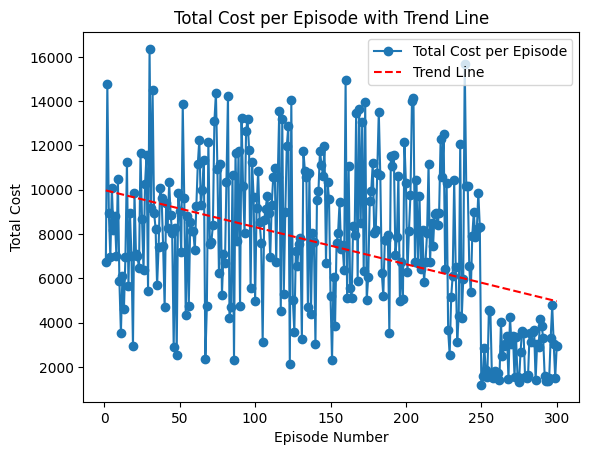

Model power: 3.04494006532453
slope -16.734521494683275
Lowest cost among all episodes: 1188.8269115398405


In [7]:
import numpy as np
from math import ceil
from scipy.stats import norm
from scipy.stats import linregress
import geopy.distance
import random
import matplotlib.pyplot as plt

class sSpolicy:
    def __init__(self, nStores=4, num_trucks=4):
        self.data = dict()
        self.nStores = nStores
        self.num_trucks = num_trucks
        self.S = 70
        self.s = 55
        
        ## Latitute coordinates; First element is depot
        self.lat = np.array([52.4572735973313,
                             52.533031250357,
                             52.5326620602486,
                             52.4965099365104,
                             52.4921203344399
                             ])
        
        ## Longitude coordinates, first element is depot
        self.lon = np.array([13.3878670887734,
                             13.387585268824,
                             13.398873880729,
                             13.4224855541126,
                             13.4226572154896,
                             ])
        
        self.data['distance_matrix'] = np.zeros(shape = [self.nStores + 1, self.nStores + 1])
        
        # Variable transport cost per unit distance
        self.transportCost = 5
        
        # Fixed transport cost per used route
        self.fixedTransportCost = 100
        
        # The distance matrix is in the end the cost matrix. We take the distance
        # between coordinates and multiply it with the variable transportCost
        for i in range(self.nStores + 1):
            for j in range(self.nStores + 1):
                coords_1 = (self.lat[i], self.lon[i])
                coords_2 = (self.lat[j], self.lon[j])
                self.data['distance_matrix'][i][j] = geopy.distance.geodesic(coords_1, coords_2).km * self.transportCost
                                           
        # The vehicle capacity, the number of vehicles
        self.data['vehicle_capacity'] = 50
        self.data['num_vehicles'] = 4

        # Information of the stores (holding cost, lost-sales cost, capacity)
        self.c_holding = 100 
        self.c_lost = 100
        self.capacity = 1000
        self.orderUpTo = 100
        
    #Demand follows a normal distribution -  Derived from the demand table provided
    def demand(self):
        demand = [
            ceil(abs(np.random.normal(17, 7, 1)[0])),
            ceil(abs(np.random.normal(14, 6, 1)[0])),
            ceil(abs(np.random.normal(13, 4, 1)[0])),
            ceil(abs(np.random.normal(16, 6, 1)[0]))
        ]
        
        return demand
    #Action space is in steps of 1
    def define_actions(self):
        actions = list(range(0, int(self.orderUpTo) + 1, 1))
        return actions

    #Reset function is to reset the environment everytime at the start of the episode
    def reset(self):
        self.inventories = 70
        return self.inventories

    #Step taken at each episode
    def step(self, q_table,epsilon, discount_factor=0.6):
        # Call the action definition
        actions = self.define_actions()
        global a
        a += 1
        
        # Initialize costs and other variables
        costs = []
        inventory = [0]*4
        replenishment = [0]*4
        
        # Get current inventories
        current_inventories = self.reset()
        
        # Calculate demand
        current_demand = self.demand()
        replenishment_needed = [0]*4

        if a >= creating_table:
            epsilon = random.random()

        inventory=[0]*4

        # Calculate replenishment needed for each store
        for i in range(self.nStores):
            inventory[i] = self.S - current_demand[i]
            if inventory[i] <= self.s:
                replenishment_needed[i] = max(0, self.S - inventory[i])
            else:
                replenishment_needed[i]=0
            found = False
            #if replenishment_needed[i] <= self.s:
            for key in q_table.keys(): #finding whether the replenishment_needed is already in the q_table or not
                if key[0] == replenishment_needed[i]:
                    found = True
                    break
            if a >= creating_table and found==True: #and epsilon >= 0.2: #Here if epsilon is commented, it depicts greedy strategy, if not, it represents the epsilon greedy strategy
                    # Exploit: choose action from Q-table
                finding = []
                for key,value in q_table.items(): #getting the minimum value of replenishment for replenishment_needed present in the table
                    if key[0]==replenishment_needed[i]:
                        finding.append(value)
                new_find = []
                for j in finding:
                    if j > replenishment_needed[i] and j:
                        new_find.append(j)
                
                replenishment[i] = min(new_find) #Getting the minimum value that has the lowest cost. Basically we are choosing the best reward   
                #intha value q table la update pannanum
            else:
            # Explore: choose a random action
                #create table here
                replenishment[i] = random.choice([a for a in actions if a > replenishment_needed[i]])
                tuple = (replenishment_needed[i],replenishment[i])
                if tuple not in q_table:
                    q_table[(replenishment_needed[i],replenishment[i])] = replenishment[i] # Use cost directly for value. Since it is just a reference for choosing the best action here.
                    
        #Initializing other variables for calculating the costs involved in each episode
        num_trucks = self.num_trucks
        trucks_load = [0]*4
        capacity = [0]*4
        replenished_by_trucks = [0]*4
        routes = [[] for _ in range(num_trucks)]
        num_trucks_used = 0
        lost_sales = 0
        total_distance = 0
        truck_index = 0

        #Printing the parameters for our reference
        print("replenishment_needed",replenishment_needed)
        print("replenishment",replenishment)
        print("Old Inventory position is",inventory)
        new_inventory = [0,0,0,0]
        for i in range(len(replenishment)):
            new_inventory[i]=inventory[i]+replenishment[i]
        print("New Iventory postion is",new_inventory)

        #Replenishment is carried out by the trucks
        for j in range(len(replenishment)):
            if replenishment[j] != 0:
                total_distance += self.data['distance_matrix'][0][j + 1]  # Add distance from depot to store
                if replenishment[j] <= self.data['vehicle_capacity']:
                    replenished_by_trucks[truck_index] = replenishment[j]
                    routes[truck_index].append(j)
                    truck_index += 1
                else:
                    while replenishment[j] > 0 and truck_index < num_trucks:
                        if replenishment[j] > self.data['vehicle_capacity']:
                            replenished_by_trucks[truck_index] = self.data['vehicle_capacity']
                            replenishment[j] -= self.data['vehicle_capacity']
                            routes[truck_index].append(j)
                            lost_sales += replenishment[j]
                            replenishment[j] = 0
                            truck_index += 1
                
                if truck_index >= num_trucks:
                    lost_sales += replenishment[j]
                    replenishment[j] = 0
            else:
                replenished_by_trucks[j] = 0
            
        # Calculate the total cost
        variable_transport_cost = total_distance * self.transportCost
        fixed_transport_cost = (num_trucks - np.count_nonzero(replenished_by_trucks == 0)) * self.fixedTransportCost
        lost_sales_cost = lost_sales * self.c_lost
        replenishment_cost = sum(replenishment) * 10
        total_cost = variable_transport_cost + fixed_transport_cost + lost_sales_cost + replenishment_cost
        print("Total cost for %s is %s" % (a,total_cost))
        return inventory, replenishment, trucks_load, replenished_by_trucks, routes, lost_sales, total_distance, total_cost

# Run the algorithm for 60 episodes
a=0 #A variable used for calculating the number of episodes to trigger exploitation when needed.
num_episodes = 300 #total number of episodes
creating_table = 250 #Number of episodes that use exploration strategy by choosing random action and evaluating its cost
explore = 0 #Flag varable for reference
total_costs = [] #List of total costs incurred in each episodes. This is further used in plotting
q_table = {} #Initializing q_table for appending values in the form of tuples. It enables us to use Q-Learning to choose the best action learned from experience
# Set epsilon for exploration-exploitation
epsilon = 0.2 

for episode in range(num_episodes):
    # Initialize an instance of sSpolicy class for each episode
    ssp = sSpolicy()
    
    
    
    # Run the step method to get the total cost
    _, _, _, replenished_by_trucks, _, _, _, total_cost = ssp.step(q_table, epsilon)
    
    # Append the total cost to the list
    total_costs.append(total_cost)
    
    # Print Q-table after each episode for debugging
    print(f"Q-table after episode {episode+1}: {q_table}")

# Print total costs for all episodes
for i, cost in enumerate(total_costs):
    print(f"Total cost for episode {i+1}: {cost}")



# Plot total costs for all episodes
plt.plot(range(1, num_episodes + 1), total_costs, marker='o', label='Total Cost per Episode')

# Calculate the trend line
slope, intercept, r_value, p_value, std_err = linregress(range(1, num_episodes + 1), total_costs)
trend_line = [slope * x + intercept for x in range(1, num_episodes + 1)]

# Plot the trend line
plt.plot(range(1, num_episodes + 1), trend_line, color='red', linestyle='--', label='Trend Line')
plt.xlabel('Episode Number')
plt.ylabel('Total Cost')
plt.title('Total Cost per Episode with Trend Line')
plt.legend()
plt.show()

#testing the power of this model:For comparing the model with different episodes and startegies
exploration_cost = sum(total_costs[:50]) / 50
exploitation_cost = sum(total_costs[-40:]) / 40
model_power = exploration_cost / exploitation_cost
print(f"Model power: {model_power}")
print("slope",slope)
# Calculate the lowest cost among all episodes
lowest_cost = min(total_costs)
print(f"Lowest cost among all episodes: {lowest_cost}")
